<a href="https://colab.research.google.com/github/kayeneii/Orbital-Congestion/blob/main/Final_udl_elset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data import UDL

In [ ]:
import requests, base64

# 1. Encode username and password for Basic Auth
basicAuth = "Basic " + base64.b64encode(b"username:password").decode("ascii")

# 2. API URL (adjust epoch/satNo as needed)
url = "https://unifieddatalibrary.com/udl/elset?epoch=2025-08-20T00:00:00.000000Z..2025-08-21T00:00:00.000000Z"

# 3. Make the GET request
result = requests.get(url, headers={"Authorization": basicAuth}, verify=False)

# 4. See if it worked
print(result.status_code)
print(result.json()[:2])  # print first 2 rows

import pandas as pd

data= result.json()
df = pd.json_normalize(data)
print(df.head())

/Users/veronicaspasion/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'unifieddatalibrary.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


200
[{'idElset': 'b89e7e2e-f031-4e3f-808f-8e86bda524a1', 'classificationMarking': 'U', 'satNo': 46015, 'epoch': '2025-08-20T23:59:29.525856Z', 'meanMotion': 12.32726941, 'idOnOrbit': '46015', 'eccentricity': 0.13870004, 'inclination': 51.381, 'raan': 341.2448, 'argOfPerigee': 294.0105, 'meanAnomaly': 52.1776, 'revNo': 21454, 'bStar': 0.0031091904, 'meanMotionDot': 0.00016191, 'meanMotionDDot': 0.0, 'semiMajorAxis': 7915.723, 'period': 116.814, 'apogee': 9013.634, 'perigee': 6817.812, 'line1': '1 46015U 11037HS  25232.99964729 +.00016191 +00000+0 +31092-2 0 99990', 'line2': '2 46015  51.3810 341.2448 1387000 294.0105  52.1776 12.32726941214543', 'createdAt': '2025-08-22T22:08:00.521Z', 'createdBy': 'system.ob-ingest', 'source': '18th SPCS', 'dataMode': 'REAL', 'algorithm': 'SGP4', 'origNetwork': 'OPS1'}, {'idElset': '417cda4a-7a4e-4800-b897-0064197143d3', 'classificationMarking': 'U', 'satNo': 62850, 'epoch': '2025-08-20T23:58:48.147168Z', 'meanMotion': 2.17372782, 'idOnOrbit': '62850',

## Save raw JSON, robust parse, and verify row counts

In [ ]:
# Robust parse (array / {"results": [...]} / JSON Lines) + traceability hash
import json, hashlib

raw_text = result.text

# Save exact raw payload (unchanged)
with open("udl_raw.json","w", encoding="utf-8") as f:
    f.write(raw_text)
print("SHA256(raw):", hashlib.sha256(raw_text.encode("utf-8")).hexdigest())

def parse_any_udl_json(text:str):
    try:
        d = json.loads(text)
        if isinstance(d, dict) and "results" in d:
            return d["results"]
        if isinstance(d, list):
            return d
    except json.JSONDecodeError:
        pass
    # JSON Lines fallback
    return [json.loads(line) for line in text.splitlines() if line.strip()]

payload = parse_any_udl_json(raw_text)
print("Rows in API payload (ground truth):", len(payload))

# Normalize again for validation (doesn't replace your df)
df_rawcheck = pd.json_normalize(payload)
assert len(df_rawcheck) == len(payload), "Mismatch payload vs df_rawcheck"
print("✅ df_rawcheck matches payload length")

SHA256(raw): fd0b3829697aa0b82a67c13657c1e24baf4acc9e87eef354999a9ab7339be3ea
Rows in API payload (ground truth): 30000
✅ df_rawcheck matches payload length


## Cleaning + altitude & region

In [ ]:
import numpy as np

# Numeric conversions (only if needed)
for c in ["semiMajorAxis","eccentricity","inclination","perigee","apogee","meanMotion","raan","satNo"]:
    if c in df.columns and not pd.api.types.is_numeric_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Epoch to datetime (only if not already)
if "epoch" in df.columns and not np.issubdtype(df["epoch"].dtype, np.datetime64):
    df["epoch"] = pd.to_datetime(df["epoch"], errors="coerce", utc=True)

# Derived columns (create once)
R_EARTH = 6378.137  # km
if "alt_km" not in df.columns and "semiMajorAxis" in df.columns:
    df["alt_km"] = df["semiMajorAxis"] - R_EARTH

if "region" not in df.columns and "alt_km" in df.columns:
    df["region"] = pd.cut(
        df["alt_km"], bins=[-1e6, 2000, 30000, 45000],
        labels=["LEO","MEO","GEO+"], include_lowest=True
    )

print(df["region"].value_counts(dropna=False).sort_index())

LEO     27752
MEO       822
GEO+     1416
NaN        10
Name: region, dtype: int64


## EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def show_eda(df, numeric_cols=None, top_n_missing=20):
    """
    Render schema, missingness, numeric summary, and samples inline.
    Optionally pass numeric_cols to control which columns get numeric stats.
    """
    display(pd.DataFrame({"rows":[len(df)], "cols":[df.shape[1]]}).rename(index={0:"shape"}))

    # 1) Schema overview
    schema = pd.DataFrame({
        "column": df.columns,
        "dtype": [str(df[c].dtype) for c in df.columns],
        "n_null": [df[c].isna().sum() for c in df.columns],
        "n_unique": [df[c].nunique(dropna=True) for c in df.columns],
    }).sort_values(["n_null","column"], ascending=[False, True]).reset_index(drop=True)
    print("— Schema overview (top):")
    display(schema.head(30))

    # 2) Missingness (table + bar chart)
    miss = df.isna().sum().sort_values(ascending=False)
    print("— Missing values per column (top):")
    display(miss.head(top_n_missing).to_frame("n_missing"))
    plt.figure(figsize=(10,4))
    miss.head(top_n_missing).plot(kind="bar")
    plt.title(f"Top {top_n_missing} columns by missing values")
    plt.ylabel("Count"); plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    plt.show()

    # 3) Numeric summary
    if numeric_cols is None:
        # guess numeric columns
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if numeric_cols:
        stats = (df[numeric_cols]
                 .describe(percentiles=[.01,.05,.5,.95,.99])
                 .T.sort_index())
        print("— Numeric summary:")
        display(stats)

    # 4) Samples
    print("— Sample head(10):")
    display(df.head(10))
    print("— Sample tail(10):")
    display(df.tail(10))
    print("— Sample random(20):")
    display(df.sample(min(20, len(df)), random_state=42))

,rows,cols
shape,30000,34


— Schema overview (top):


,column,dtype,n_null,n_unique
0,descriptor,object,29999,1
1,ephemType,float64,29999,1
2,uct,object,29999,1
3,origObjectId,object,29972,1
4,idOnOrbit,object,28,20364
5,revNo,float64,28,18515
6,satNo,Int64,28,20364
7,region,category,10,3
8,algorithm,object,1,1
9,alt_km,float64,0,19335


— Missing values per column (top):


,n_missing
ephemType,29999
descriptor,29999
uct,29999
origObjectId,29972
satNo,28
idOnOrbit,28
revNo,28
region,10
algorithm,1
dataMode,0


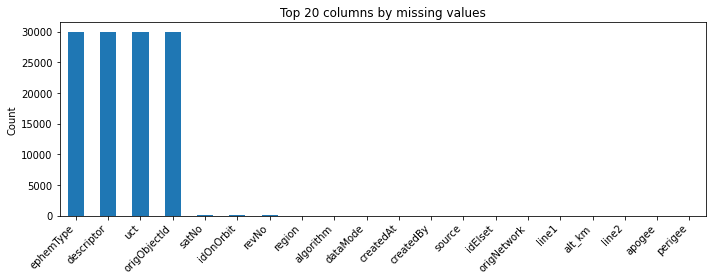

— Numeric summary:


,count,mean,std,min,1%,5%,50%,95%,99%,max
alt_km,30000.0,2755.410950,7875.257667,183.941000,346.865980,417.571750,668.027000,21142.909600,36091.851260,91250.495000
apogee,30000.0,9477.354508,8990.251665,6564.108000,6726.553090,6798.296400,7075.815500,42134.538850,42590.584270,181885.872000
eccentricity,30000.0,0.018272,0.089215,0.000000,0.000053,0.000099,0.000737,0.040798,0.641038,0.863236
inclination,30000.0,70.201001,26.316771,0.001900,0.047297,13.529865,74.005700,99.079850,102.018219,144.640700
meanMotion,30000.0,13.583696,3.400205,0.284601,0.991927,1.901541,14.678228,15.497107,15.742151,16.332049
perigee,30000.0,8789.741389,7460.752399,6494.016000,6668.392870,6749.241600,6968.206000,14718.892450,42394.977650,45201.222000
raan,30000.0,190.648748,112.250183,0.018200,3.392781,16.412540,204.801100,347.537255,357.125949,359.980500
semiMajorAxis,30000.0,9133.547950,7875.257667,6562.078000,6725.002980,6795.708750,7046.164000,27521.046600,42469.988260,97628.632000


— Sample head(10):


,idElset,classificationMarking,satNo,epoch,meanMotion,idOnOrbit,eccentricity,inclination,raan,argOfPerigee,...,dataMode,algorithm,origNetwork,origObjectId,uct,descriptor,ephemType,alt_km,region,isStarlink
0,b89e7e2e-f031-4e3f-808f-8e86bda524a1,U,46015,2025-08-20 23:59:29.525856+00:00,12.327269,46015,0.138700,51.3810,341.2448,294.0105,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,1537.586,LEO,False
1,417cda4a-7a4e-4800-b897-0064197143d3,U,62850,2025-08-20 23:58:48.147168+00:00,2.173728,62850,0.736195,21.1401,8.8137,312.0809,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,18794.675,MEO,False
2,19cf9a9e-0921-43e1-91fd-8488211960d6,U,35135,2025-08-20 23:58:43.622400+00:00,14.222034,35135,0.008085,98.5690,244.9743,254.3456,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,817.911,LEO,False
3,1d439713-0d85-48ad-8349-9132c4b66b5f,U,42166,2025-08-20 23:58:07.248864+00:00,13.965372,42166,0.014342,82.8805,120.7318,338.3076,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,905.811,LEO,False
4,9123918e-c62c-437d-8847-e0ab64f60b18,U,65127,2025-08-20 23:56:43.305216+00:00,14.911667,65127,0.001432,49.9897,127.6366,344.6221,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,594.296,LEO,False
5,3100ec2a-91f8-44eb-9e20-c14101213093,U,42662,2025-08-20 23:56:38.688000+00:00,1.002700,42662,0.000588,0.0342,104.4708,119.4099,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,35787.099,GEO+,False
6,520353f1-ab32-4fd5-b304-7f80afa37b19,U,40239,2025-08-20 23:56:20.359968+00:00,14.613483,40239,0.008800,74.0308,133.5476,274.0732,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,688.824,LEO,False
7,39fbe462-32f5-4c0b-ba94-b77fed777fda,U,42140,2025-08-20 23:55:52.351680+00:00,13.496202,42140,0.019645,83.1420,330.8129,280.0134,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,1073.656,LEO,False
8,b9a16cc7-3d23-46fb-8bf9-b385bcd0bd38,U,41430,2025-08-20 23:54:31.841568+00:00,14.459690,41430,0.003498,99.0174,65.7994,320.5400,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,738.845,LEO,False
9,c8a3a0ac-dcff-4ce0-acf8-e041d630fd9e,U,12966,2025-08-20 23:50:27.597408+00:00,14.110030,12966,0.003400,82.9423,133.7372,82.3339,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,855.941,LEO,False


— Sample tail(10):


,idElset,classificationMarking,satNo,epoch,meanMotion,idOnOrbit,eccentricity,inclination,raan,argOfPerigee,...,dataMode,algorithm,origNetwork,origObjectId,uct,descriptor,ephemType,alt_km,region,isStarlink
29990,61124721-ac9f-4a28-93cc-fcfe9d1c591b,U,62713,2025-08-20 12:00:46.006272+00:00,14.960176,62713,0.000363,97.7318,311.9744,83.5588,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,579.216,LEO,False
29991,c1668805-ef46-4223-b9a9-fefaf26f284b,U,63447,2025-08-20 12:00:45.572544+00:00,15.396162,63447,0.000118,53.1601,358.2674,39.2917,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,447.243,LEO,True
29992,57767150-500e-407a-96bf-b7fd7e74c37d,U,57134,2025-08-20 12:00:44.152992+00:00,15.025374,57134,0.000133,43.0036,275.3220,270.5075,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,559.075,LEO,True
29993,e4caa80a-3051-4e49-bde4-6ae755b2ddc7,U,42957,2025-08-20 12:00:42.710112+00:00,14.342178,42957,0.000211,86.4028,150.8921,85.6412,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,777.667,LEO,False
29994,e007e221-cb7f-422b-95f4-28562f267707,U,130,2025-08-20 12:00:38.765952+00:00,13.993290,130,0.008131,66.7699,277.4260,145.1345,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,896.120,LEO,False
29995,8ca2d40e-972d-4912-9e23-2f11bcd0a6de,U,55636,2025-08-20 12:00:38.460960+00:00,14.983318,55636,0.000315,70.0017,351.6586,269.1666,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,572.050,LEO,True
29996,c68f35f1-d11b-4e30-b77e-1c840d861a4f,U,39072,2025-08-20 12:00:36.589536+00:00,12.622656,39072,0.000094,52.0044,78.6542,71.1308,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,1413.607,LEO,False
29997,9cfc9fc1-affc-43dc-9150-fcefe84eb32c,U,64860,2025-08-20 12:00:35.176032+00:00,15.475479,64860,0.000042,97.6029,86.2516,318.0692,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,423.902,LEO,True
29998,ff066b31-09b0-4d94-a659-51ff0f383b8b,U,61524,2025-08-20 12:00:30.273696+00:00,15.301804,61524,0.000115,53.1624,356.6457,70.8581,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,475.274,LEO,True
29999,5815d3b5-5cd2-43d0-b571-965d2d284ff0,U,49737,2025-08-20 12:00:29.956608+00:00,15.088368,49737,0.000127,53.2195,332.2945,105.0674,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,539.753,LEO,True


— Sample random(20):


,idElset,classificationMarking,satNo,epoch,meanMotion,idOnOrbit,eccentricity,inclination,raan,argOfPerigee,...,dataMode,algorithm,origNetwork,origObjectId,uct,descriptor,ephemType,alt_km,region,isStarlink
2308,8d4b2eac-1e28-4328-9e38-b761a474f882,U,65020,2025-08-20 22:00:03.000096+00:00,15.539851,65020,0.000130,53.1598,150.2620,111.9876,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,405.104,LEO,True
22404,822756b9-bd7a-4314-a6e9-ea5315c3c8a8,U,23670,2025-08-20 13:56:28.889088+00:00,1.002963,23670,0.000062,13.3466,14.8670,179.0291,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,35779.726,GEO+,False
23397,10e0d49a-da40-409b-9357-19469953c0ff,U,55341,2025-08-20 13:44:49.168320+00:00,15.025352,55341,0.000139,43.0038,313.3675,268.0299,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,559.082,LEO,True
25058,d8de551a-7562-436c-90b4-8ff0be3c43a7,U,3743,2025-08-20 13:23:49.783776+00:00,12.206747,3743,0.026115,56.6615,299.1256,66.9401,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,1589.604,LEO,False
2664,764056d2-3447-496d-84e1-d1758d13ef2e,U,49218,2025-08-20 21:56:28.856832+00:00,13.134697,49218,0.000154,87.9000,19.9102,97.3416,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,1209.767,LEO,False
8511,9f1958ed-1503-407b-ab6f-5be470548d56,U,62236,2025-08-20 19:51:03.162816+00:00,15.396349,62236,0.000091,53.1580,63.5096,101.1041,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,447.188,LEO,True
5148,9009743f-7ff0-4d9d-938c-c124f751f0bc,U,11267,2025-08-20 21:13:16.135392+00:00,14.915568,11267,0.001635,82.5232,287.0205,13.9593,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,593.081,LEO,False
7790,8478fd8b-2d84-44bd-ab71-da396568af11,U,52294,2025-08-20 20:09:21.493440+00:00,15.088366,52294,0.000118,53.2166,280.7726,82.3550,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,539.754,LEO,True
11311,0e5e937d-f481-457d-9d67-45c79d5a230c,U,47279,2025-08-20 18:45:04.082400+00:00,13.124430,47279,0.000176,87.8852,50.3529,84.6380,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,1213.723,LEO,False
19043,014ab5ae-e16a-4a93-ae44-63dd1545db37,U,26721,2025-08-20 14:35:35.061216+00:00,2.245644,26721,0.704353,1.8719,20.3350,3.9562,...,REAL,SGP4,OPS1,NaN,NaN,NaN,NaN,18254.328,MEO,False


In [ ]:
# If you already created derived columns, you can pass numeric_cols explicitly:
num_cols = [c for c in ["semiMajorAxis","alt_km","perigee","apogee","inclination","eccentricity","raan","meanMotion"]
            if c in df.columns]
show_eda(df, numeric_cols=num_cols, top_n_missing=20)

## SatCat merge

In [ ]:
satcat_url = "https://celestrak.org/pub/satcat.csv"
satcat = pd.read_csv(satcat_url)
satcat["NORAD_CAT_ID"] = pd.to_numeric(satcat["NORAD_CAT_ID"], errors="coerce").astype("Int64")

df["satNo"] = pd.to_numeric(df["satNo"], errors="coerce").astype("Int64")
dfm = df.merge(
    satcat[["NORAD_CAT_ID","OBJECT_TYPE","OBJECT_NAME","OWNER"]],
    left_on="satNo", right_on="NORAD_CAT_ID", how="left"
)
dfm["OBJECT_TYPE"] = dfm["OBJECT_TYPE"].fillna("UNKNOWN")

# LEO-only table
leo_m = dfm[(dfm["alt_km"] >= 0) & (dfm["alt_km"] < 2000)].copy()
summary = (leo_m["OBJECT_TYPE"].value_counts(dropna=False).to_frame("Count"))
summary["Percent"] = (summary["Count"]/len(leo_m)*100).round(2)
display(summary)
summary.to_csv("leo_object_type_breakdown.csv")
print("✅ Saved: leo_object_type_breakdown.csv")

,Count,Percent
PAY,18528,66.76
DEB,7371,26.56
R/B,1628,5.87
UNKNOWN,132,0.48
UNK,93,0.34


✅ Saved: leo_object_type_breakdown.csv


## Starlink tagging

In [ ]:
import re
tle_text = requests.get("https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle").text
starlink_ids = [int(m.group(1)) for m in re.finditer(r"1 (\d{5})", tle_text)]

df["isStarlink"] = df["satNo"].isin(starlink_ids)
print(df["isStarlink"].value_counts(dropna=False))

False    20325
True      9675
<NA>         0
Name: isStarlink, dtype: Int64


In [ ]:
# --- Merge UDL dataset (df) with SatCat ---
satcat_url = "https://celestrak.org/pub/satcat.csv"
satcat = pd.read_csv(satcat_url)

# Convert IDs to integers (safe)
satcat["NORAD_CAT_ID"] = pd.to_numeric(satcat["NORAD_CAT_ID"], errors="coerce").astype("Int64")
df["satNo"] = pd.to_numeric(df["satNo"], errors="coerce").astype("Int64")

# Merge SatCat classification into UDL data
dfm = df.merge(
    satcat[["NORAD_CAT_ID","OBJECT_TYPE","OBJECT_NAME","OWNER"]],
    left_on="satNo", right_on="NORAD_CAT_ID", how="left"
)

# Fill missing classification
dfm["OBJECT_TYPE"] = dfm["OBJECT_TYPE"].fillna("UNKNOWN")

print("🔹 Total UDL rows:", len(df))
print("🔹 After merge:", len(dfm))
print("🔹 Missing OBJECT_TYPE:", (dfm['OBJECT_TYPE']=="UNKNOWN").sum())

# --- LEO-only subset (<2000 km) ---
leo_m = dfm[(dfm["alt_km"] >= 0) & (dfm["alt_km"] < 2000)].copy()

# Summary by object type
summary = (leo_m["OBJECT_TYPE"].value_counts(dropna=False).to_frame("Count"))
summary["Percent"] = (summary["Count"]/len(leo_m)*100).round(2)

# Save + display
display(summary)
summary.to_csv("leo_object_type_breakdown.csv")
print("✅ Saved: leo_object_type_breakdown.csv")

# Quick peek at merged dataset
print("\nSample merged rows:")
display(dfm[["satNo","OBJECT_NAME","OWNER","OBJECT_TYPE","alt_km","inclination","epoch"]].head(10))

🔹 Total UDL rows: 30000
🔹 After merge: 30000
🔹 Missing OBJECT_TYPE: 136


,Count,Percent
PAY,18528,66.76
DEB,7371,26.56
R/B,1628,5.87
UNKNOWN,132,0.48
UNK,93,0.34


✅ Saved: leo_object_type_breakdown.csv

Sample merged rows:


,satNo,OBJECT_NAME,OWNER,OBJECT_TYPE,alt_km,inclination,epoch
0,46015,FREGAT DEB,CIS,DEB,1537.586,51.3810,2025-08-20 23:59:29.525856+00:00
1,62850,NVS-02 (IRNSS-1K),IND,PAY,18794.675,21.1401,2025-08-20 23:58:48.147168+00:00
2,35135,FENGYUN 1C DEB,PRC,DEB,817.911,98.5690,2025-08-20 23:58:43.622400+00:00
3,42166,COSMOS 1275 DEB,CIS,DEB,905.811,82.8805,2025-08-20 23:58:07.248864+00:00
4,65127,GEESAT-4 J,PRC,PAY,594.296,49.9897,2025-08-20 23:56:43.305216+00:00
5,42662,CHINASAT 16 (SJ-13),PRC,PAY,35787.099,0.0342,2025-08-20 23:56:38.688000+00:00
6,40239,COSMOS 2251 DEB,CIS,DEB,688.824,74.0308,2025-08-20 23:56:20.359968+00:00
7,42140,COSMOS 1275 DEB,CIS,DEB,1073.656,83.1420,2025-08-20 23:55:52.351680+00:00
8,41430,NOAA 16 DEB,US,DEB,738.845,99.0174,2025-08-20 23:54:31.841568+00:00
9,12966,COSMOS 1275 DEB,CIS,DEB,855.941,82.9423,2025-08-20 23:50:27.597408+00:00


## LEO subset

In [ ]:
leo = df[(df["alt_km"] >= 0) & (df["alt_km"] < 2000)].copy()
print("LEO objects:", len(leo))

LEO objects: 27752


## Altitude hotspot

Top 5 LEO altitude hotspots (km, count):
   500–600  : 7188
   400–500  : 5326
   700–800  : 2562
   800–900  : 2500
   900–1000 : 1942


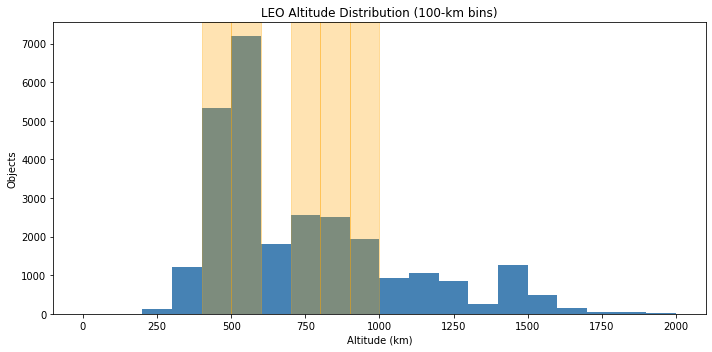

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(0, 2100, 100)
hist, edges = np.histogram(leo["alt_km"].dropna(), bins=bins)
top_idx = hist.argsort()[::-1][:5]
hotspots = [(int(edges[i]), int(edges[i+1]), int(hist[i])) for i in top_idx]

print("Top 5 LEO altitude hotspots (km, count):")
for low, high, c in hotspots:
    print(f"  {low:>4}–{high:<4} : {c}")

plt.figure(figsize=(10,5))
plt.bar(edges[:-1], hist, width=100, align="edge", color="steelblue")
for low, high, _ in hotspots:
    plt.axvspan(low, high, color="orange", alpha=0.3)
plt.title("LEO Altitude Distribution (100-km bins)")
plt.xlabel("Altitude (km)"); plt.ylabel("Objects")
plt.tight_layout(); plt.savefig("leo_altitude_hotspots.png", dpi=300); plt.show()

## RAAN_Inclination hetmaps (LEO, and Starlink overlay)

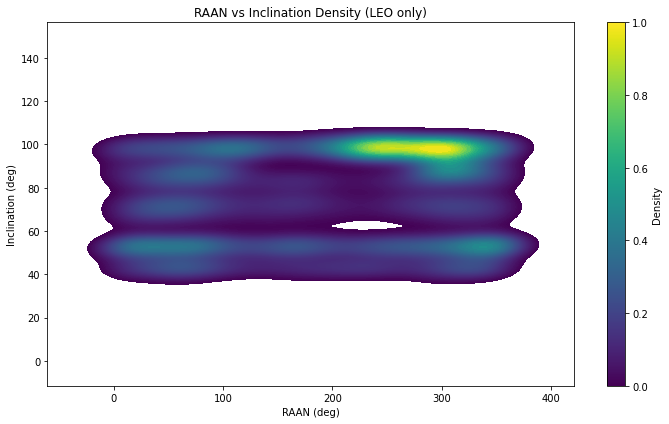

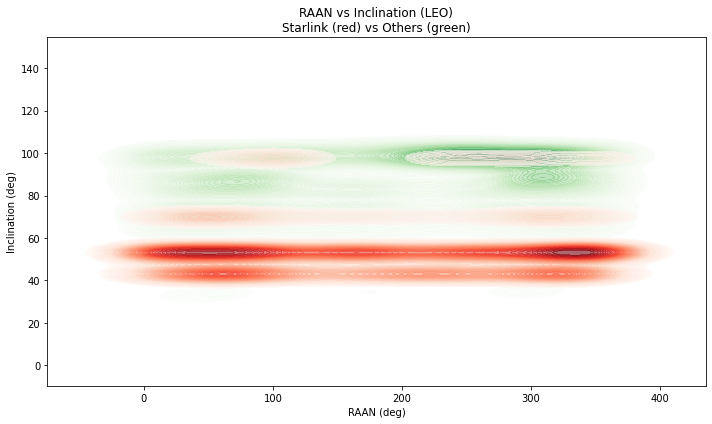

In [ ]:
import seaborn as sns

# LEO density
leo_ri = leo.dropna(subset=["raan","inclination"])
plt.figure(figsize=(10,6))
sns.kdeplot(x=leo_ri["raan"], y=leo_ri["inclination"], cmap="viridis",
            fill=True, levels=100, thresh=0.05)
plt.title("RAAN vs Inclination Density (LEO only)")
plt.xlabel("RAAN (deg)"); plt.ylabel("Inclination (deg)")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), label="Density")
plt.tight_layout(); plt.savefig("raan_inclination_LEO.png", dpi=300); plt.show()

# Starlink vs Others overlay (LEO)
star = leo_ri[leo_ri["isStarlink"] == True]
others = leo_ri[leo_ri["isStarlink"] == False]

plt.figure(figsize=(10,6))
sns.kdeplot(x=others["raan"], y=others["inclination"], cmap="Greens",
            fill=True, levels=60, thresh=0.05, alpha=0.5)
sns.kdeplot(x=star["raan"], y=star["inclination"], cmap="Reds",
            fill=True, levels=60, thresh=0.05, alpha=0.6)
plt.title("RAAN vs Inclination (LEO)\nStarlink (red) vs Others (green)")
plt.xlabel("RAAN (deg)"); plt.ylabel("Inclination (deg)")
plt.tight_layout(); plt.savefig("raan_inclination_LEO_starlink_vs_others.png", dpi=300); plt.show()

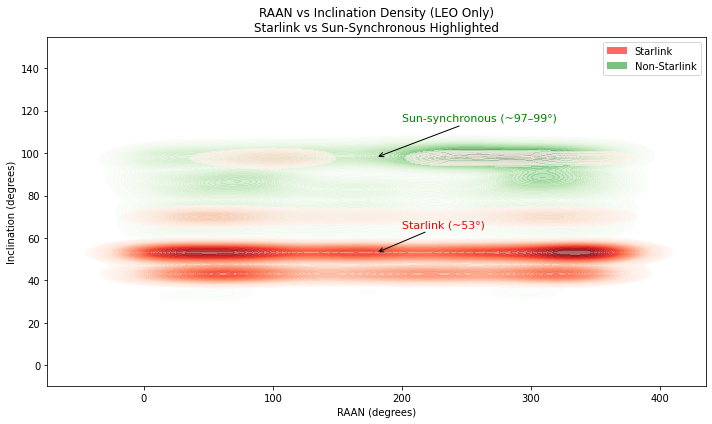

✅ Saved: raan_inclination_LEO_starlink_vs_sso.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# --- Filter for LEO (<2000 km) ---
#leo = df[(df["alt_km"] < 2000)].dropna(subset=["raan", "inclination"])

# Split Starlink vs Others
starlink = leo[leo["isStarlink"] == True]
others   = leo[leo["isStarlink"] == False]

plt.figure(figsize=(10,6))

# Non-Starlink (green)
sns.kdeplot(
    x=others["raan"], y=others["inclination"],
    cmap="Greens", fill=True, levels=60, thresh=0.05, alpha=0.5
)

# Starlink (red)
sns.kdeplot(
    x=starlink["raan"], y=starlink["inclination"],
    cmap="Reds", fill=True, levels=60, thresh=0.05, alpha=0.6
)

plt.title("RAAN vs Inclination Density (LEO Only)\nStarlink vs Sun-Synchronous Highlighted")
plt.xlabel("RAAN (degrees)")
plt.ylabel("Inclination (degrees)")

# Legend
handles = [
    Patch(facecolor="red", alpha=0.6, label="Starlink"),
    Patch(facecolor="green",   alpha=0.5, label="Non-Starlink")
]
plt.legend(handles=handles, loc="upper right")

# --- Add annotations ---
# Starlink ~53°
plt.annotate(
    "Starlink (~53°)",
    xy=(180, 53), xycoords="data",
    xytext=(200, 65), textcoords="data",
    arrowprops=dict(facecolor="orange", arrowstyle="->"),
    fontsize=11, color="red"
)

# Sun-synchronous ~97–99°
plt.annotate(
    "Sun-synchronous (~97–99°)",
    xy=(180, 98), xycoords="data",
    xytext=(200, 115), textcoords="data",
    arrowprops=dict(facecolor="blue", arrowstyle="->"),
    fontsize=11, color="green"
)

plt.tight_layout()
plt.savefig("raan_inclination_LEO_starlink_vs_sso.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Saved: raan_inclination_LEO_starlink_vs_sso.png")


## Debris Hotspot (LEO 100-km bands)

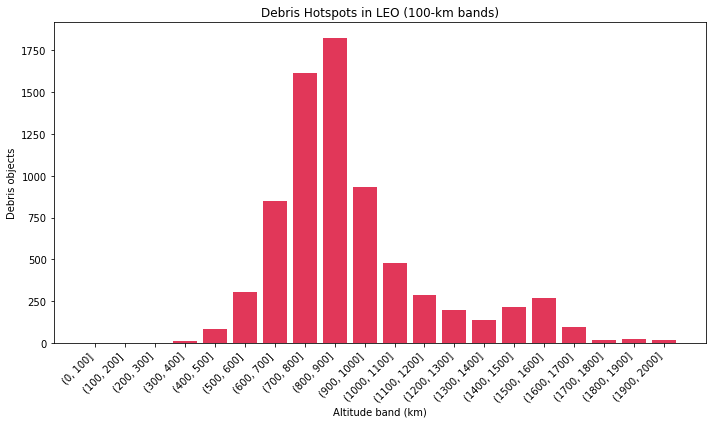

In [ ]:
bins = np.arange(0, 2100, 100)
leo_m["alt_band"] = pd.cut(leo_m["alt_km"], bins=bins)

debris_counts = (leo_m[leo_m["OBJECT_TYPE"] == "DEB"]
                 .groupby("alt_band").size())

plt.figure(figsize=(10,6))
plt.bar(debris_counts.index.astype(str), debris_counts.values, color="crimson", alpha=0.85)
plt.title("Debris Hotspots in LEO (100-km bands)")
plt.xlabel("Altitude band (km)"); plt.ylabel("Debris objects")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.savefig("leo_debris_hotspots.png", dpi=300); plt.show()

## Decay-risk in LEO (perigee < 300 km)

[LEO] Decay candidates (<300 km perigee): 180/27752 (0.65%)


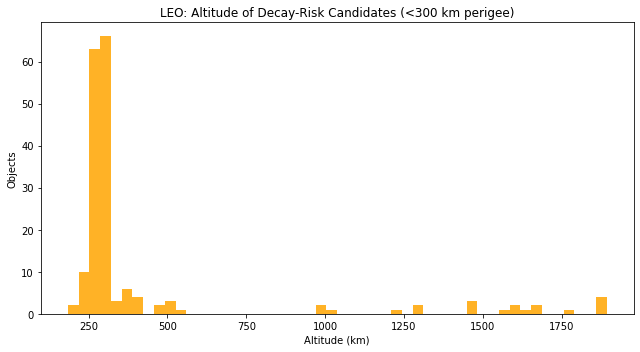

✅ Saved: leo_decay_candidates_lt300km.csv


In [ ]:
leo_per = leo.copy()
leo_per["perigee"] = pd.to_numeric(leo_per["perigee"], errors="coerce")

# Convert perigee to altitude if values look like Earth-centered radius
med_peri = leo_per["perigee"].dropna().median()
if pd.notna(med_peri) and med_peri > 6500:
    leo_per["perigee_km"] = leo_per["perigee"] - R_EARTH
else:
    leo_per["perigee_km"] = leo_per["perigee"]

leo_per["decay_risk"] = leo_per["perigee_km"] < 300

n_total = len(leo_per)
n_decay = int(leo_per["decay_risk"].sum())
print(f"[LEO] Decay candidates (<300 km perigee): {n_decay}/{n_total} ({100*n_decay/n_total:.2f}%)")

plt.figure(figsize=(9,5))
plt.hist(leo_per.loc[leo_per["decay_risk"], "alt_km"].dropna(), bins=50, color="orange", alpha=0.85)
plt.title("LEO: Altitude of Decay-Risk Candidates (<300 km perigee)")
plt.xlabel("Altitude (km)"); plt.ylabel("Objects")
plt.tight_layout(); plt.savefig("leo_decay_risk_hist.png", dpi=300); plt.show()

# Export flagged list (appendix/report)
cols = [c for c in ["satNo","perigee_km","alt_km","inclination","raan","eccentricity","epoch","region"] if c in leo_per.columns]
leo_per.loc[leo_per["decay_risk"], cols].to_csv("leo_decay_candidates_lt300km.csv", index=False)
print("✅ Saved: leo_decay_candidates_lt300km.csv")

## Starlink vs non-Starlink by inclination (LEO)

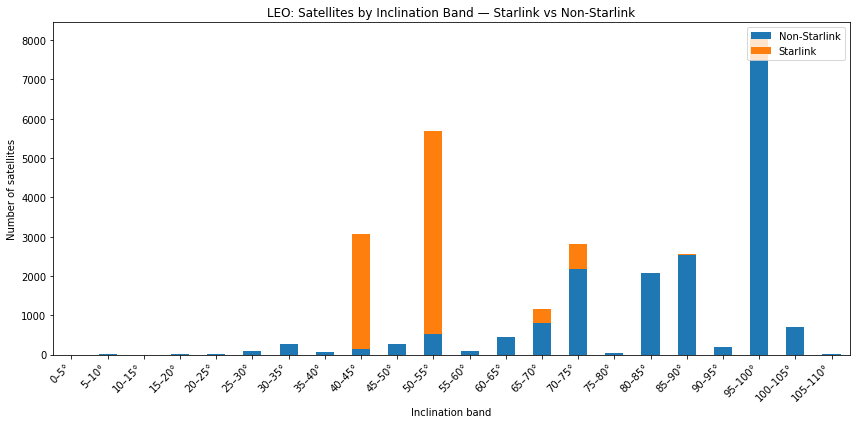

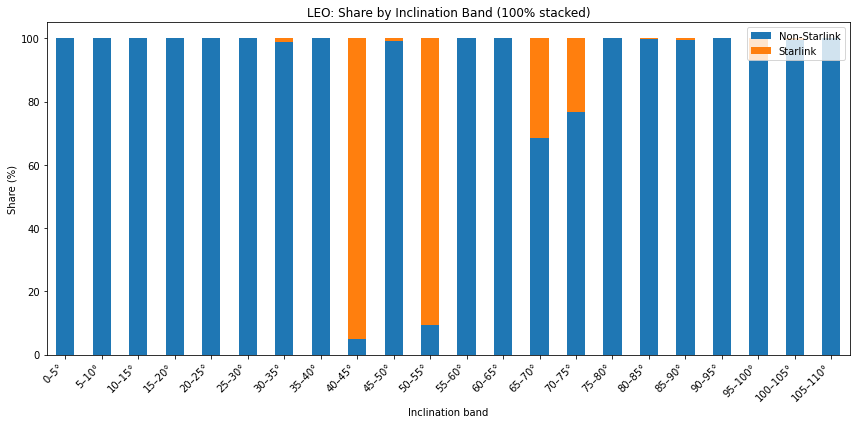

✅ Saved: leo_inclination_band_starlink_breakdown.csv


In [ ]:
edges = np.arange(0, 111, 5)  # 0,5,10,...,110
labels = [f"{edges[i]}–{edges[i+1]}°" for i in range(len(edges)-1)]

leo_bands = leo.copy()
leo_bands["inclination"] = pd.to_numeric(leo_bands["inclination"], errors="coerce")
leo_bands["inc_band"] = pd.cut(leo_bands["inclination"], bins=edges, labels=labels, right=False)

by_band = (leo_bands.dropna(subset=["inc_band"])
           .groupby(["inc_band","isStarlink"])
           .size()
           .unstack(fill_value=0)
           .rename(columns={False:"Non-Starlink", True:"Starlink"}))

# Keep only populated bands
by_band = by_band[(by_band.sum(axis=1) > 0)]

# Counts plot
plt.figure(figsize=(12,6))
by_band.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("LEO: Satellites by Inclination Band — Starlink vs Non-Starlink")
plt.xlabel("Inclination band"); plt.ylabel("Number of satellites")
plt.legend(loc="upper right"); plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.savefig("leo_inc_bands_starlink_vs_others_counts.png", dpi=300); plt.show()

# 100% stacked share
share = by_band.div(by_band.sum(axis=1), axis=0) * 100
plt.figure(figsize=(12,6))
share.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("LEO: Share by Inclination Band (100% stacked)")
plt.xlabel("Inclination band"); plt.ylabel("Share (%)")
plt.legend(loc="upper right"); plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.savefig("leo_inc_bands_starlink_vs_others_share.png", dpi=300); plt.show()

# Export table
out = by_band.copy()
out["Total"] = out.sum(axis=1)
out["% Starlink"] = (out["Starlink"] / out["Total"] * 100).round(1)
out.sort_values("Total", ascending=False).to_csv("leo_inclination_band_starlink_breakdown.csv")
print("✅ Saved: leo_inclination_band_starlink_breakdown.csv")

## Key Numbers Recap (for slides/report)

In [ ]:
# === KEY NUMBERS RECAP ===
import json, numpy as np
from pathlib import Path

OUTDIR = Path("."); OUTDIR.mkdir(exist_ok=True)

# Safety rebuilds if needed
if "alt_km" not in df.columns and "semiMajorAxis" in df.columns:
    df["alt_km"] = pd.to_numeric(df["semiMajorAxis"], errors="coerce") - R_EARTH
if "region" not in df.columns:
    df["region"] = pd.cut(df["alt_km"], bins=[-1e6, 2000, 30000, 45000],
                          labels=["LEO","MEO","GEO+"], include_lowest=True)
leo = df[(df["alt_km"] >= 0) & (df["alt_km"] < 2000)].copy()

# Starlink fallback
if "isStarlink" not in df.columns: df["isStarlink"] = False

# SatCat fallback
if "OBJECT_TYPE" not in df.columns:
    try:
        satcat = pd.read_csv("https://celestrak.org/pub/satcat.csv")
        satcat["NORAD_CAT_ID"] = pd.to_numeric(satcat["NORAD_CAT_ID"], errors="coerce").astype("Int64")
        df["satNo"] = pd.to_numeric(df["satNo"], errors="coerce").astype("Int64")
        df_sc = df.merge(
            satcat[["NORAD_CAT_ID","OBJECT_TYPE","OBJECT_NAME","OWNER"]],
            left_on="satNo", right_on="NORAD_CAT_ID", how="left"
        )
        df_sc["OBJECT_TYPE"] = df_sc["OBJECT_TYPE"].fillna("UNKNOWN")
    except Exception:
        df_sc = df.copy(); df_sc["OBJECT_TYPE"] = "UNKNOWN"
else:
    df_sc = df.copy()
leo_sc = df_sc[(df_sc["alt_km"] >= 0) & (df_sc["alt_km"] < 2000)].copy()

# Totals
total_objects = int(len(df))
total_leo     = int(len(leo))

# Debris in LEO
debris_leo = int((leo_sc["OBJECT_TYPE"] == "DEB").sum())
debris_share_leo = (debris_leo / total_leo * 100) if total_leo else 0.0

# Starlink counts
starlink_total = int(df["isStarlink"].sum())
starlink_leo   = int(leo["isStarlink"].sum())
starlink_share_leo = (starlink_leo / total_leo * 100) if total_leo else 0.0

# LEO hotspots (100-km bins)
bins = np.arange(0, 2100, 100)
hist, edges = np.histogram(leo["alt_km"].dropna(), bins=bins)
top_idx = hist.argsort()[::-1][:5]
hotspots = [{"low_km": int(edges[i]), "high_km": int(edges[i+1]), "count": int(hist[i])} for i in top_idx]

# Decay risk (<300 km perigee)
leo_per = leo.copy()
leo_per["perigee"] = pd.to_numeric(leo_per.get("perigee"), errors="coerce")
med_peri = leo_per["perigee"].dropna().median()
if pd.notna(med_peri) and med_peri > 6500:
    leo_per["perigee_km"] = leo_per["perigee"] - R_EARTH
else:
    leo_per["perigee_km"] = leo_per["perigee"]
leo_per["decay_risk"] = leo_per["perigee_km"] < 300
decay_n = int(leo_per["decay_risk"].sum())
decay_share = (decay_n / total_leo * 100) if total_leo else 0.0

# Inclination bands (quick)
edges_inc = np.arange(0, 111, 5)
leo["inclination"] = pd.to_numeric(leo["inclination"], errors="coerce")
leo["inc_band"] = pd.cut(leo["inclination"], bins=edges_inc, right=False)
inc_counts = (leo.groupby("inc_band").size().sort_values(ascending=False).head(3))
top_inclination_bands = [str(idx) for idx in inc_counts.index]

kpis = {
    "total_objects_all_regions": total_objects,
    "total_objects_LEO": total_leo,
    "debris_in_LEO_count": debris_leo,
    "debris_in_LEO_share_pct": round(debris_share_leo, 2),
    "starlink_total": starlink_total,
    "starlink_in_LEO_count": starlink_leo,
    "starlink_in_LEO_share_pct": round(starlink_share_leo, 2),
    "decay_risk_LEO_count": decay_n,
    "decay_risk_LEO_share_pct": round(decay_share, 2),
    "top5_LEO_altitude_hotspots_100km_bins": hotspots,
    "top3_inclination_bands_LEO": top_inclination_bands
}

print("\n=== SpaceAware – Key Numbers Recap ===")
print(f"All objects: {kpis['total_objects_all_regions']}")
print(f"LEO objects: {kpis['total_objects_LEO']}")
print(f"Debris in LEO: {kpis['debris_in_LEO_count']}  ({kpis['debris_in_LEO_share_pct']}%)")
print(f"Starlink (all): {kpis['starlink_total']}")
print(f"Starlink in LEO: {kpis['starlink_in_LEO_count']}  ({kpis['starlink_in_LEO_share_pct']}%)")
print(f"Decay-risk in LEO (<300 km perigee): {kpis['decay_risk_LEO_count']}  ({kpis['decay_risk_LEO_share_pct']}%)")
print("Top 5 LEO altitude hotspots (100-km bins):")
for h in kpis["top5_LEO_altitude_hotspots_100km_bins"]:
    print(f"  {h['low_km']:>4}–{h['high_km']:<4} km : {h['count']} objects")
print("Top 3 inclination bands in LEO:", ", ".join(kpis["top3_inclination_bands_LEO"]))

# Save KPI files
Path("spaceaware_kpis.json").write_text(json.dumps(kpis, indent=2))
with open("spaceaware_kpis.txt","w") as f:
    f.write("SpaceAware – Key Numbers Recap\n")
    f.write("="*34 + "\n")
    f.write(f"All objects: {kpis['total_objects_all_regions']}\n")
    f.write(f"LEO objects: {kpis['total_objects_LEO']}\n")
    f.write(f"Debris in LEO: {kpis['debris_in_LEO_count']}  ({kpis['debris_in_LEO_share_pct']}%)\n")
    f.write(f"Starlink (all): {kpis['starlink_total']}\n")
    f.write(f"Starlink in LEO: {kpis['starlink_in_LEO_count']}  ({kpis['starlink_in_LEO_share_pct']}%)\n")
    f.write(f"Decay-risk in LEO (<300 km perigee): {kpis['decay_risk_LEO_count']}  ({kpis['decay_risk_LEO_share_pct']}%)\n")
    f.write("Top 5 LEO altitude hotspots (100-km bins):\n")
    for h in kpis["top5_LEO_altitude_hotspots_100km_bins"]:
        f.write(f"  {h['low_km']:>4}–{h['high_km']:<4} km : {h['count']} objects\n")
    f.write("Top 3 inclination bands in LEO: " + ", ".join(kpis["top3_inclination_bands_LEO"]) + "\n")

print("✅ Saved: spaceaware_kpis.json, spaceaware_kpis.txt")


=== SpaceAware – Key Numbers Recap ===
All objects: 30000
LEO objects: 27752
Debris in LEO: 7371  (26.56%)
Starlink (all): 9675
Starlink in LEO: 9666  (34.83%)
Decay-risk in LEO (<300 km perigee): 180  (0.65%)
Top 5 LEO altitude hotspots (100-km bins):
   500–600  km : 7188 objects
   400–500  km : 5326 objects
   700–800  km : 2562 objects
   800–900  km : 2500 objects
   900–1000 km : 1942 objects
Top 3 inclination bands in LEO: [95, 100), [50, 55), [40, 45)
✅ Saved: spaceaware_kpis.json, spaceaware_kpis.txt


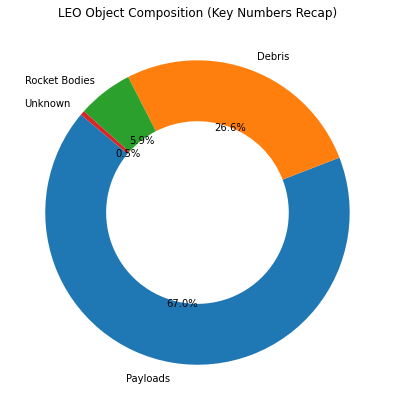

In [ ]:
import matplotlib.pyplot as plt

# Example key numbers (replace with your actual summary table)
data = {
    "Payloads": 18528,
    "Debris": 7371,
    "Rocket Bodies": 1628,
    "Unknown": 132
}

labels = list(data.keys())
sizes = list(data.values())

plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
plt.title("LEO Object Composition (Key Numbers Recap)")
plt.savefig("key_numbers_donut.png", dpi=300)
plt.show()

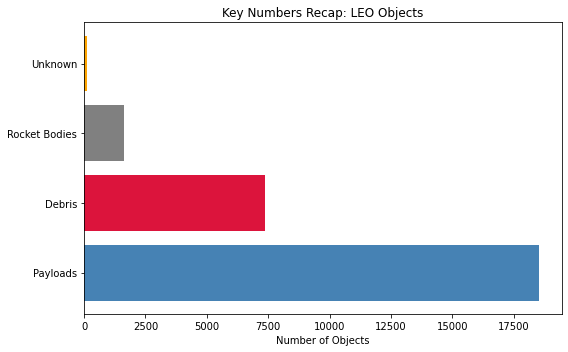

In [ ]:
import matplotlib.pyplot as plt

labels = list(data.keys())
sizes = list(data.values())

plt.figure(figsize=(8,5))
plt.barh(labels, sizes, color=["steelblue","crimson","gray","orange"])
plt.title("Key Numbers Recap: LEO Objects")
plt.xlabel("Number of Objects")
plt.tight_layout()
plt.savefig("key_numbers_bar.png", dpi=300)
plt.show()

In [ ]:
# df  = your UDL dataset (raw orbital data) merged with celestrak for stalink tagging
# dfm = df already merged with SatCat (OBJECT_TYPE, OBJECT_NAME, OWNER, etc.)

# Ensure satNo is consistent
df["satNo"] = pd.to_numeric(df["satNo"], errors="coerce").astype("Int64")
dfm["satNo"] = pd.to_numeric(dfm["satNo"], errors="coerce").astype("Int64")

# Merge df (orbital info) + dfm (classification metadata)
master = df.merge(
    dfm.drop(columns=["alt_km","inclination","epoch"], errors="ignore"),  # avoid duplicate orbit cols
    on="satNo", how="left", suffixes=("_udl","_meta")
)

print("✅ Master dataset built")
print("Rows:", len(master))
print("Columns:", master.shape[1])
print(master.head())

✅ Master dataset built
Rows: 51490
Columns: 68
                            idElset_udl classificationMarking_udl  satNo  \
0  b89e7e2e-f031-4e3f-808f-8e86bda524a1                         U  46015   
1  b89e7e2e-f031-4e3f-808f-8e86bda524a1                         U  46015   
2  417cda4a-7a4e-4800-b897-0064197143d3                         U  62850   
3  19cf9a9e-0921-43e1-91fd-8488211960d6                         U  35135   
4  1d439713-0d85-48ad-8349-9132c4b66b5f                         U  42166   

                             epoch  meanMotion_udl idOnOrbit_udl  \
0 2025-08-20 23:59:29.525856+00:00       12.327269         46015   
1 2025-08-20 23:59:29.525856+00:00       12.327269         46015   
2 2025-08-20 23:58:48.147168+00:00        2.173728         62850   
3 2025-08-20 23:58:43.622400+00:00       14.222034         35135   
4 2025-08-20 23:58:07.248864+00:00       13.965372         42166   

   eccentricity_udl  inclination  raan_udl  argOfPerigee_udl  ...  \
0          0.13870

,low_km,high_km,Debris,Starlink,Non-Starlink,Total
1,400,500,85,3505,1596,5186
0,500,600,307,5130,1575,7012
2,700,800,1615,2,696,2313
3,800,900,1825,1,472,2298
4,900,1000,935,2,608,1545


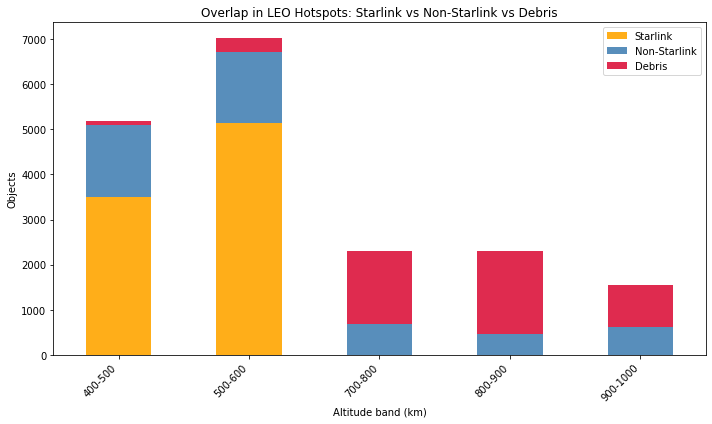

In [ ]:
# === Overlap analysis: debris vs Starlink vs non-Starlink in hotspots ===
bins = np.arange(0, 2100, 100)
leo_sc["alt_bin"] = pd.cut(leo_sc["alt_km"], bins=bins, right=False)

rows = []
for h in kpis["top5_LEO_altitude_hotspots_100km_bins"]:
    low, high = h["low_km"], h["high_km"]
    mask  = (leo_sc["alt_bin"] == pd.Interval(left=low, right=high, closed="left"))
    shell = leo_sc.loc[mask]

    # counts
    debris   = int((shell["OBJECT_TYPE"] == "DEB").sum())
    starlink = int(((shell["OBJECT_TYPE"] == "PAY") & (shell["isStarlink"].fillna(False))).sum())
    nonstar  = int(((shell["OBJECT_TYPE"] == "PAY") & (~shell["isStarlink"].fillna(False))).sum())

    rows.append({
        "low_km": low, "high_km": high,
        "Debris": debris, "Starlink": starlink, "Non-Starlink": nonstar,
        "Total": debris + starlink + nonstar
    })

overlap_df = pd.DataFrame(rows).sort_values("low_km")
display(overlap_df)

# --- Plot stacked bar ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
(overlap_df
 .set_index(overlap_df.apply(lambda r: f"{r['low_km']}-{r['high_km']}", axis=1))
 [["Starlink","Non-Starlink","Debris"]]
 .plot(kind="bar", stacked=True, color=["orange","steelblue","crimson"], alpha=0.9, ax=plt.gca())
)

plt.title("Overlap in LEO Hotspots: Starlink vs Non-Starlink vs Debris")
plt.xlabel("Altitude band (km)")
plt.ylabel("Objects")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.savefig("leo_overlap_hotspots.png", dpi=300)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


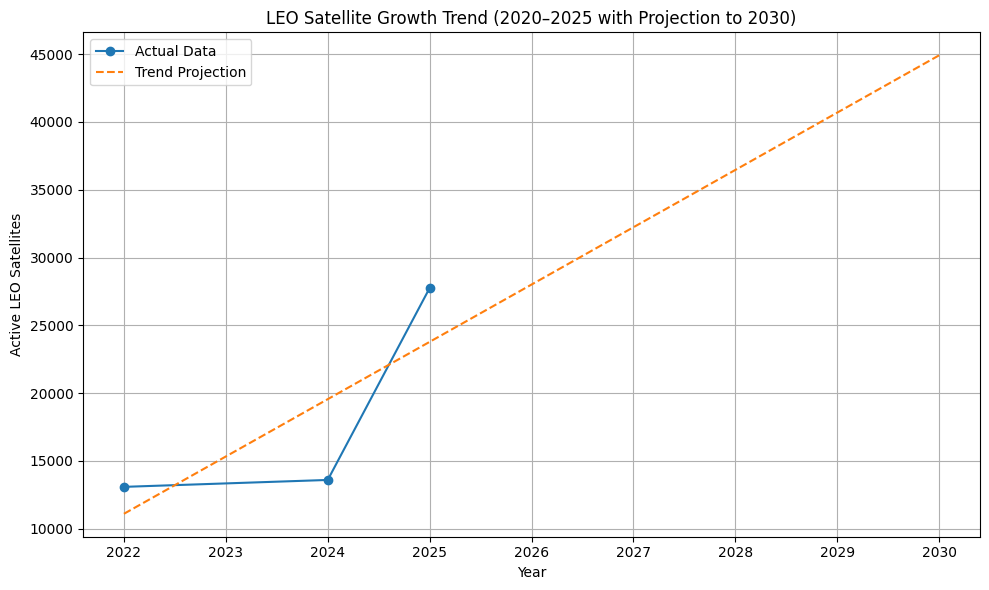

Approximate CAGR (2020–2025): 28.48%


In [ ]:
# === Growth-trend analysis: ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Historical LEO active satellite counts
data = {
    "year": [2022, 2024,2025],
    "leo_active_satellites": [13085,13595,27752]
}

df_grow = pd.DataFrame(data)

# Create a "year index" for regression (so 2020 = 0, 2021 = 1, etc.)
df_grow["year_index"] = df_grow["year"] - df_grow["year"].min()

# Independent (X) and dependent (y) variables
X = df_grow[["year_index"]]
y = df_grow["leo_active_satellites"]

# Fit linear regression model
model = LinearRegression().fit(X, y)

# Predict for existing years + future projection to 2030
future_years = np.arange(df_grow["year"].min(), 2031)
future_index = future_years - df_grow["year"].min()
y_pred = model.predict(future_index.reshape(-1, 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_grow["year"], y, marker="o", label="Actual Data")
plt.plot(future_years, y_pred, linestyle="--", label="Trend Projection")
plt.xlabel("Year")
plt.ylabel("Active LEO Satellites")
plt.title("LEO Satellite Growth Trend (2020–2025 with Projection to 2030)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# CAGR calculation (2020 to 2025)
start, end = df_grow["leo_active_satellites"].iloc[0], df_grow["leo_active_satellites"].iloc[-1]
years = df_grow["year"].iloc[-1] - df_grow["year"].iloc[0]
cagr = (end / start) ** (1 / years) - 1
print(f"Approximate CAGR (2020–2025): {cagr:.2%}")

In [ ]:
display(df_grow)

,year,leo_active_satellites,year_index
0,2022,13085,0
1,2024,13595,2
2,2025,27752,3
